# How to Survive Predicting Survival on the Titanic
***
***This is my first Kaggle Kernel and my first real attempt at walking through a competition.***  I'm newer to advanced machine learning, moderately experienced with data science, decent with python, and learning more about Jupyter notebooks by the day. I'm sure that I will be either influenced by other kernels or may even use techniques directly from them. I will do everything I can to make sure I give credit where it is due. If you have any comments on my approach or would like to propose ways to expand my approach, I'd be happy to listen and learn. If you find something that appears to be uncredited, please please let me know and I will correct asap. With that, let me first credit <a href='https://www.udemy.com/user/joseporitlla/'>Jose Portilla</a>  and his wonderful Udemy courses. I learned a lot of visualization tools through those courses and those will definitely appear here.

My attempt here is to put everything I've learned over the last year of dabbling in this realm into practice in a massively complete kernel, where all aspects of Exploratory Data Analysis are done, along with a fairly detailed exposition on common algorithms that can be used for this data set.

### Workflow ###
*** 
1 <a href='#eda'>Exploratory Data Analysis (EDA)</a>  
&nbsp;&nbsp;&nbsp; 1.1 <a href='#eda_1'>Basic Feature Transformations and Removals</a>  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.1a <a href='#eda_1a'>Drop Irrelevant Features</a>  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.1b <a href='#eda_1b'>Basic Feature Engineering</a>  
&nbsp;&nbsp;&nbsp; 1.2 <a href='#eda_2'>Statists & Visualizations</a>  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.2a <a href='#eda_2a'>Basic Stats</a>  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.2b <a href='#eda_2b'>Correlations</a>  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.2c <a href='#eda_2c'>Distributions</a>  
&nbsp;&nbsp;&nbsp; 1.3 <a href='#eda_3'>Basic Interpretations</a>  

2 <a href='#eng'>Feature Engineering (FE)</a>  
&nbsp;&nbsp;&nbsp; 2.1 <a href='#eng_1'>Continous Transformations</a>  
&nbsp;&nbsp;&nbsp; 2.2 <a href='#eng_2'>Imputation</a>  
&nbsp;&nbsp;&nbsp; 2.3 <a href='#eng_3'>Categorical Binarization</a>   
&nbsp;&nbsp;&nbsp; 2.4 <a href='#eng_4'>Normalization</a>     
&nbsp;&nbsp;&nbsp; 2.5 <a href='#eng_5'>Importance & PCA</a>    
  
#### Update Notes
v0.0 - 12/12/2017 - Initial Kernel creation
***

## Imports and Initializations

In [1]:
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
#Scikit Learn imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [3]:
# Initializations
%matplotlib inline
sns.set_style('whitegrid')

# turn off warnings (if you want to)
import warnings
turn_off_warnings = True
if turn_off_warnings: 
    warnings.filterwarnings('ignore')

## Some General Functions

In [4]:
# I'll need a figure counter
fig_counter = (x for x in range(1, 10000))

# Also a figure labeler
def label_fig_n():
    n = next(fig_counter)
    display(Markdown("#### Figure {} ####".format(n)));
    return n
    
# Add n, percentages to top of barcharts
# from: https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
def show_bar_pct(ax, total, fontsize):
    for p in ax.patches:
        height = p.get_height()
        if not np.isnan(height):
            ax.text(p.get_x()+p.get_width()/2., height + 3, '{:d}\n({:.2f})'.format(int(height), height/total), 
                    ha="center", fontsize=fontsize)

<a id='eda'></a> 
# Part 1: Exploratory Data Analysis (EDA)# 
***

In [5]:
# Load the data into a pandas DataFrame and display the head. Create a copy that will be kept unaltered
train_df = pd.read_csv("train.csv")
unaltered_train_df = train_df.copy()
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## What is known about the data?

From the competition site:
***
Variable: Definition - Key  

survival: Survival - 0=No, 1=Yes  
pclass:	Ticket class - 1=1st, 2=2nd, 3=3rd  
sex: Sex  
Age: Age in years	
sibsp: # of siblings / spouses aboard the Titanic	
parch: # of parents / children aboard the Titanic	
ticket: Ticket number	
fare: Passenger fare	
cabin: Cabin number	
embarked:Port of Embarkation - C=Cherbourg, Q=Queenstown, S=Southampton  

Variable Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...  
Sibling = brother, sister, stepbrother, stepsister  
Spouse = husband, wife (mistresses and fiancés were ignored)  

parch: The dataset defines family relations in this way...  
Parent = mother, father  
Child = daughter, son, stepdaughter, stepson  
Some children travelled only with a nanny, therefore parch=0 for them.  
***

<a id='eda_1'></a>  
## 1.1) EDA - Feature Transformations and Removals ##
***
Before moving on to explore how the different features relate to Survival, some questions must be answered:  
    **a) *Are there features that are completely useless and should be dropped so that time and space are not wasted on them?* **  
    **b) *Do any of the remaining features need some basic feature engineering before they can be explored?* **
***




<a id='eda_1a'></a>  
### 1.1a) EDA - Are there features that can be dropped? ##
***
Do any of the Features have data that has no bearing on whether a passenger lived or died? The likely candidates, in order of most useless, are:
* **PassengerId** - This appears to be the order in which passengers bought the ticket (i.e, ticket manifest) - not important
* **Ticket** - This is likely the ticket number, and like PassengerID, this may not have value
* **Cabin** - The cabin location, may have use  
* **Name** - However, there may be useful in here for later, e.g. Mr. Mrs. Miss. Dr. etc.

#### PassengerId - Is there any correlation between ID and survival?

In [7]:
train_df['PassengerId'].corr(train_df['Survived'])

-0.0050066607670664915

Pretty clear that PassengerId does not have any correlation with survival, so drop it (inplace!)

In [8]:
train_df.drop(["PassengerId"], axis=1, inplace=True)

#### Ticket, is there information that might be useful?
It's possible there may be some unique information in there; start with a description of unique values and frequencies

In [9]:
train_df['Ticket'].describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

In [10]:
# How about the top 10 most frequent
train_df['Ticket'].value_counts().nlargest(10)

CA. 2343        7
1601            7
347082          7
CA 2144         6
3101295         6
347088          6
S.O.C. 14879    5
382652          5
17421           4
4133            4
Name: Ticket, dtype: int64

In [11]:
# How about the bottom 10 which are all single unique
train_df['Ticket'].value_counts().nsmallest(10)

A/4 45380    1
113043       1
349223       1
13567        1
236853       1
347063       1
112059       1
7598         1
364848       1
PC 17610     1
Name: Ticket, dtype: int64

I don't think there's anything useful in here. So let's drop this column

In [12]:
train_df.drop(["Ticket"], axis=1, inplace=True)

#### Cabin, is there information that might be useful?   
It's possible the lettering or numbering of the cabin might have something; start with a description and frequency again

In [13]:
train_df['Cabin'].describe()

count             204
unique            147
top       C23 C25 C27
freq                4
Name: Cabin, dtype: object

In [14]:
# How about the top 10 most frequent
train_df['Cabin'].value_counts().nlargest(10)

C23 C25 C27    4
G6             4
B96 B98        4
E101           3
D              3
F2             3
F33            3
C22 C26        3
C2             2
E67            2
Name: Cabin, dtype: int64

In [15]:
# How about the bottom 10 which are all single unique
train_df['Cabin'].value_counts().nsmallest(10)

C87      1
A5       1
B39      1
B79      1
C106     1
F E69    1
E50      1
D7       1
B4       1
E31      1
Name: Cabin, dtype: int64

**I think there is potentially useful information here.**  The first letter denotes the floor of the ship that the cabin is located.  It's quite possible that this is useful.  However, from describe(), there are only 204 known values, while there are 891 passengers. Keep it for now, and in the next section (basic feature engineering) simplify the feature to only keep the first letter of the cabin, denoting floor.

#### Name - is there information in there that might be useful?  
I think the only thing that might be useful is the honoric prefix (Mr., Mrs. Miss., etc), so what are the unique honorifics? Find them and create a new feature based on them. I know this could be considered Feature Engineering, which is coming up next, but it's easiest to do it all at once here.

In [16]:
# First split by "." (take first), then split by " " (take last)
train_df['NameTitle'] = [x.split(".")[0].split()[-1] for x in train_df['Name']]

# Show all unique values
train_df['NameTitle'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [17]:
# Show the count of all of these:
train_df['NameTitle'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Mme           1
Lady          1
Capt          1
Don           1
Jonkheer      1
Sir           1
Countess      1
Ms            1
Name: NameTitle, dtype: int64

This is pretty good. I think this can be simplified by merging some of the smaller quantity titles into others, which I'll do in the next section.  For now, drop the Name feature. 

In [18]:
train_df.drop(["Name"], axis=1, inplace=True)

<a id='eda_1b'></a>  
### 1.1b) EDA - Basic Feature Engineering ##
***
Do any of the features require some basic alterations or transformations that will make them easier to explore and visualize?

####  Cabin
As discussed above, this feature can be simplified to just be the first letter of the cabin given, which denotes floor (potentially relevant)

In [19]:
# Change the cabin value to the first letter if cabin exists
train_df['Cabin'] = train_df['Cabin'].apply(lambda x: x[0] if not pd.isnull(x) else x)
train_df['Cabin'].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

####  NameTitle
I think this can be simplified by merging some of the smaller quantity titles into others via the following:  
* Mlle, Mme, Ms -> "Miss"  
* Countess, Lady, Don, Sir, Jonkheer, Dr, Master -> "Elite"
* Major, Col, Capt -> "Military" 

In [20]:
# Convert extraneous NameTitles
ix = train_df[train_df['NameTitle'].isin(["Mlle", "Mme", "Ms"])].index
train_df['NameTitle'].loc[ix] = "Miss"

ix = train_df[train_df['NameTitle'].isin(["Countess", "Lady", "Don", "Sir", "Jonkheer", "Dr", "Master"])].index
train_df['NameTitle'].loc[ix] = "Elite"

ix = train_df[train_df['NameTitle'].isin(["Major", "Col", "Capt"])].index
train_df['NameTitle'].loc[ix] = "Military"

train_df['NameTitle'].value_counts()

Mr          517
Miss        186
Mrs         125
Elite        52
Rev           6
Military      5
Name: NameTitle, dtype: int64

#### Are there any features with invalid data?
From info(), it's known that Embark is missing 2 values, which will be dealt with later during Imputation. Before moving on to visualizing the data, make sure none of the other features have invalid data.

In [21]:
# Pclass - These should only have values 1, 2, or 3
train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [22]:
# Sex - These should only have values female or male
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [23]:
# Age - These should be between 0-100
print("Min:", train_df['Age'].min())
print("Max:", train_df['Age'].max())

Min: 0.42
Max: 80.0


In [24]:
# SibSp - this should be integers between 0 and ? (10 maybe?)
train_df['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [25]:
# Parch - this should be integers between 0 and ? (10 maybe?)
train_df['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [26]:
# Fare - this should be between 0 and ? (0 because some were employees working the boat)
print("Min:", train_df['Fare'].min())
print("Max:", train_df['Fare'].max())

Min: 0.0
Max: 512.3292


In [27]:
# Embarked - this should be either C, S, Q (will add up to 889 because 2 are missing - impute later)
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

### Great! No junk data in these other columns that need engineering
***

<a id='eda_2'></a>  
## 1.2) EDA - Statists & Visualizations ##
***
What can be statistically said about the data and are there visualizations to help understand these statistics?

<a id='eda_2a'></a>  
## 1.2a) EDA - Basic Stats ##
***
#### Question 1: How many people survived and what percentage were they of all passengers?
<a id='fig_a'></a>

#### Figure 1 ####

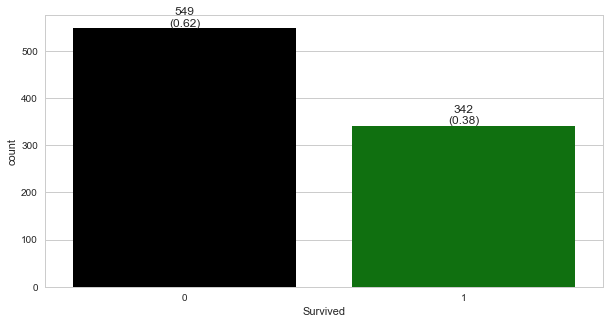

In [28]:
# Create two dataframes that are just subsamples of the main dataframe
lived_df = train_df[train_df['Survived'] == 1]
died_df  = train_df[train_df['Survived'] == 0]
n_lived  = len(lived_df)
n_died   = len(died_df)
total    = n_lived + n_died

# PLot overall surival rate
label_fig_n()
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(x='Survived', data=train_df, order=[0, 1],palette=['k', 'g'], ax=ax)        
show_bar_pct(ax, total, 12)

<a id='eda_2b'></a> 
## 1.2b) EDA - Feature Correlation ## 
***
#### Question 2: How do the different features correlate to each other and especially to survival?
Before asking this question, it's necessary to convert categorical data to numerical. Normally, it is best to do this with get_dummies or OneHotEncoder, and that will be done later. For the moment, I want to use an ordinal encoding of the categorical data, which could be done with LabelEncoder, but then it is difficult to get the integer - category pairs out. I'm going to create my own where I can control the mapping and the mapping meaning.

To do this, information about the Titanic deck layout is needed to set the values of Cabin based on highest deck=0 and lowest deck = N. Also needed is information about the Embarkment cities so that the first city = 0, and the last = N (2). All of this information is available on <a href='https://en.wikipedia.org/wiki/RMS_Titanic'>Wikipedia</a>. Set Sex and NameTitle to be female first then male.

In [29]:
# Feature dictionary for mapping
feature_dict = {"Sex":       {"female": 0, "male": 1},
                "Cabin":     {"nan": -1, "A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "T": 7},
                "Embarked":  {"nan": -1, "C": 0, "S": 1, "Q": 2},
                "NameTitle": {"Miss": 0, "Mrs": 1, "Elite": 2, "Military": 3, "Rev": 4, "Mr": 5}}

# Reverse of the dictionary, will be used to reverse map
feature_dict_rev = {feature: {feature_dict[feature][key]:key for key in feature_dict[feature]} for feature in feature_dict}

# Create function to convert categorical data to numerical
def cat_to_int(df, col, feature_dict):
    
    # Modify each categorical label of the feature to the corresponding integer, set any nan to -1
    df[col] = df[col].apply(lambda x: feature_dict[col][x] if pd.notnull(x) else -1)
    
    return df

# To show what's been created, print out feature_dict and the reverse
print("Feature Dictionary: ", feature_dict, "\n")
print("Reverse Feature Dictionary: ", feature_dict_rev)

Feature Dictionary:  {'Sex': {'female': 0, 'male': 1}, 'Cabin': {'nan': -1, 'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}, 'Embarked': {'nan': -1, 'C': 0, 'S': 1, 'Q': 2}, 'NameTitle': {'Miss': 0, 'Mrs': 1, 'Elite': 2, 'Military': 3, 'Rev': 4, 'Mr': 5}} 

Reverse Feature Dictionary:  {'Sex': {0: 'female', 1: 'male'}, 'Cabin': {-1: 'nan', 0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'T'}, 'Embarked': {-1: 'nan', 0: 'C', 1: 'S', 2: 'Q'}, 'NameTitle': {0: 'Miss', 1: 'Mrs', 2: 'Elite', 3: 'Military', 4: 'Rev', 5: 'Mr'}}


In [30]:
# Run the the categorical to integer mapping for Sex, Cabin, Embarked, and NameTitle
for col in ["Sex", "Cabin", "Embarked", "NameTitle"]:
    train_df = cat_to_int(train_df, col, feature_dict)

Just to show what's been done, make sure that the first two rows are correct.  
Row 1: Sex:Male, Cabin: NaN, Embarked:S, Title:Mr  
Row 2: Female, C, C, Mrs  

Which should then be:  
Row 1: Sex: 1, Cabin: -1, Embarked: 1, Title: 6  
Row 2: Sex: 0, Cabin: 2, Embarked: 0, Title: 1

In [31]:
train_df.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,NameTitle
0,0,3,1,22.0,1,0,7.2500,-1,1,5
1,1,1,0,38.0,1,0,71.2833,2,0,1


Ok, now make sure all rows are numerical data

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Sex          891 non-null int64
Age          714 non-null float64
SibSp        891 non-null int64
Parch        891 non-null int64
Fare         891 non-null float64
Cabin        891 non-null int64
Embarked     891 non-null int64
NameTitle    891 non-null int64
dtypes: float64(2), int64(8)
memory usage: 69.7 KB


#### Great!, all Features are now numerical data.  
The next statistic  to visualize is how well do the different the features correlate to survival. To do this, all of the original null data must be kept as null data, which requires a temporary dataframe that has null data as numerical (-1) tranformed back to null data.

In [33]:
# Create temp compy of dataframe
temp_df = train_df.copy()

# Reset Cabin
temp_df['Cabin'] = temp_df['Cabin'].apply(lambda x: np.nan if x == -1 else x)

# Reset Embarked
temp_df['Embarked'] = temp_df['Embarked'].apply(lambda x: np.nan if x == -1 else x)

temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Sex          891 non-null int64
Age          714 non-null float64
SibSp        891 non-null int64
Parch        891 non-null int64
Fare         891 non-null float64
Cabin        204 non-null float64
Embarked     889 non-null float64
NameTitle    891 non-null int64
dtypes: float64(4), int64(6)
memory usage: 69.7 KB


#### Ok, time to run correlation using seaborn heatmap
<a id='fig_b'></a>

#### Figure 2 ####

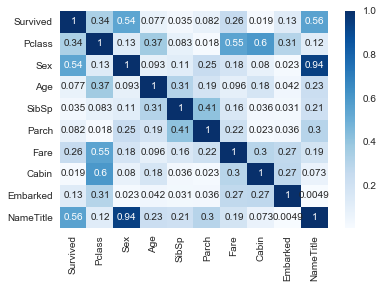

In [34]:
label_fig_n()
sns.heatmap(abs(temp_df.corr()), annot=True, cmap='Blues');

<a id='eda_2c'></a>  
## 1.2c) EDA - Feature Distributions - Histograms and KDEs ##
***
Visualize how the different features relate to Survival. As an aside here, there are ML algorithms that may be used later that require continuous features be normally distributed, which may require transformations.
<a id='fig_c'></a>

In [35]:
# # Start with the big one, pairplot
# # Code credit: https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
# label_fig_n()
# g = sns.pairplot(train_df, hue='Survived', palette='seismic', size=1.2, diag_kind='kde', 
#                  diag_kws=dict(shade=True), plot_kws=dict(s=10));

Well, firstly, I have to squint to see anything, so I'm not sure that this figure does much for me.  I already have a sense for which features have the most correlation to survival based on the correlation heatmap.  So instead of trying to decipher this massive pair plot, create individual plots for categorical data and distributions for continuous data.

### Continuous data distributions - Age & Fare ###
Do this as grid of two plots for each Feature, Age and Fare.  One plot will be a histogram with overlayed gaussian kde, and the other will be a boxplot overlayed with a swarmplot. I could use a violin plot to see similar results for the box/swarm, but the violin is closer to the kde plot and doesn't show exact outliers as well. For the the 'Fare' set of plots, chop the high end off as there are some extreme outliers well above $200. 
<a id='fig_d'></a>

In [36]:
# n = label_fig_n()
# fig, ax = plt.subplots(2, 2, figsize=(20, 15))

# sns.boxplot(x='Survived', y='Age', data=train_df[train_df['Age'].notnull()], ax=ax[0,0])
# sns.swarmplot(x='Survived', y='Age', data=train_df[train_df['Age'].notnull()], ax=ax[0,0])

# sns.boxplot(x='Survived', y='Fare', data=train_df, ax=ax[1,0])
# sns.swarmplot(x='Survived', y='Fare', data=train_df, ax=ax[1,0])

# sns.distplot(died_df[died_df['Age'].notnull()]['Age'], label='Died', color='k', ax=ax[0,1], hist_kws=dict(alpha=0.3))
# sns.distplot(lived_df[lived_df['Age'].notnull()]['Age'], label='Lived', color='g', ax=ax[0,1], hist_kws=dict(alpha=0.3))
# ax[0,1].legend()

# sns.distplot(died_df['Fare'], label='Died', color='k', ax=ax[1,1], hist_kws=dict(alpha=0.3))
# sns.distplot(lived_df['Fare'], label='Lived', color='g', ax=ax[1,1], hist_kws=dict(alpha=0.3))
# ax[1,1].legend()

# ax[0,0].set(title="Figure {}a".format(n))
# ax[0,1].set(title="Figure {}b".format(n))
# ax[1,0].set(title="Figure {}c".format(n), ylim=[-10, 200])
# ax[1,1].set(title="Figure {}d".format(n), xlim=[-20, 125]);

### Discrete data distributions - Pclass, Sex, SibSp, Parch, Cabin, Embarked, NameTitle ###
Can be observe these in a number of ways. To start, do simple count (bar) plots with survival as a hue separator
<a id='fig_e'></a>

#### Figure 3 ####

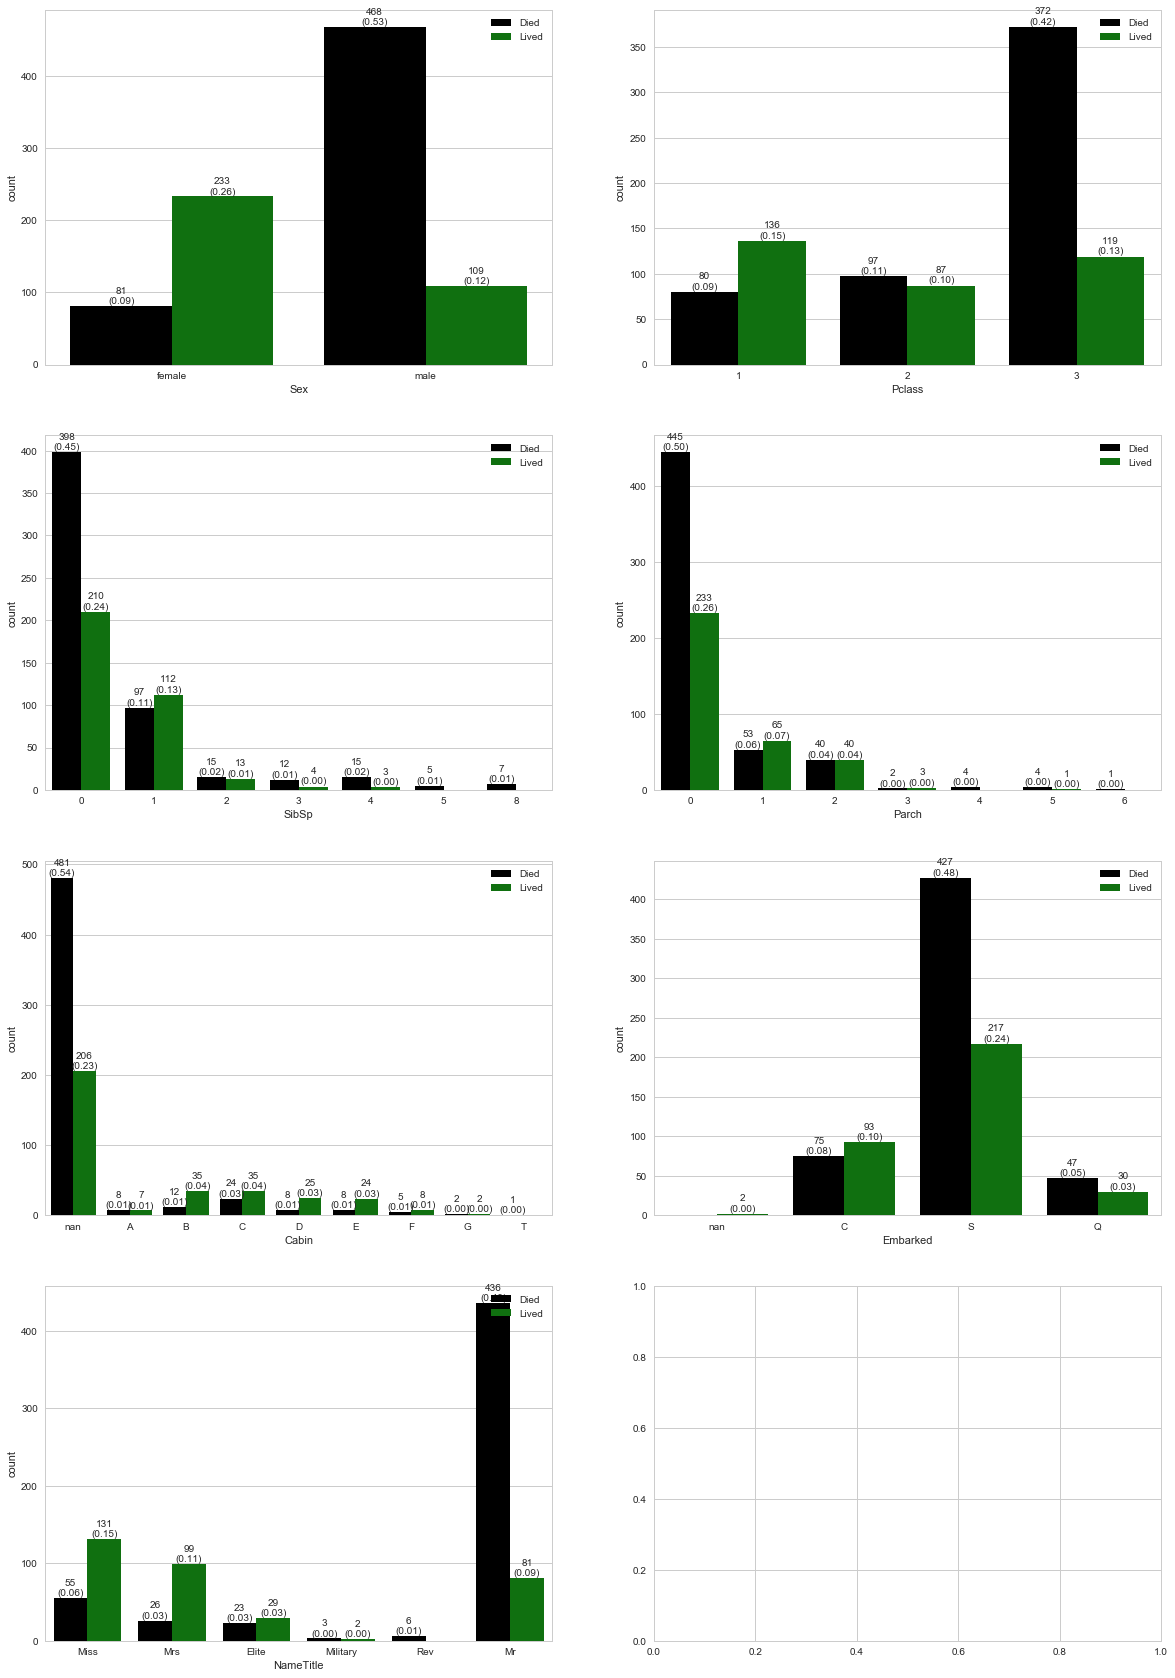

In [37]:
label_fig_n()
fig, ax = plt.subplots(4, 2, figsize=(20, 30))

for ix, col in enumerate(['Sex', 'Pclass', 'SibSp', 'Parch', 'Cabin', 'Embarked', 'NameTitle']):
    f_ax = ax[ix//2, ix%2]
    sns.countplot(x=col, hue='Survived', data=train_df, palette=['k', 'g'], ax=f_ax)
    f_ax.legend(["Died", "Lived"], loc='upper right')
    show_bar_pct(f_ax, total, 10)
    if col in feature_dict:
        labels = [int(float(x.get_text())) for x in f_ax.get_xticklabels()]
        true_labels = [feature_dict_rev[col][key] for key in labels]
        f_ax.set_xticklabels(true_labels)

<a id='eda_3'></a>  
## 3) EDA - Basic Intepretations ##
***

**What do these plots reveal? Here's my take:**  

**<a href='#fig_a'>Figure 1</a>**  
\- **Approximately 3 out 5 people died (62% to 38%)**  

**<a href='#fig_b'>Figure 2</a>**  
\- **Sex is strongly correlated with Survival (0.54)** - Can't say which here, that comes next.  

\- **NameTitle is even more so correlated to Survival (0.56)**, but this is not surprising considering Sex and NameTitle are nearly perfectly correlated (0.94). That also is not surprising as the Titles were ordered female to male. I may decide to drop the NameTitle or Sex feature later as they are clearly collinear. However, there does seem to be some distinction in NameTitle that matters as will be seen below 

\- **Pclass is decently correlated to Survival (0.34)** - *Does this mean those with higher class tickets lived? Will need to explore further.*  

\- **Pclass is strongly correlated to Fare (0.55) and Cabin (0.6)** - Not too surprising considering that a higher class ticket likely costs quite a bit more than lower class tickets and higher class tickets are higher up on the decks. *This has implications for whether the Cabin eature is to be kept considering there are so few values (only 23% of this data is complete).*  

\- **Surprisingly!, Pclass has some correlation to Embarked (0.31)** - *Does this mean that more people bought higher class tickets at one of the embarkment points?

\- One that I find a little odd, and may need more exploring - **Age has some decent correlation to Pclass (0.37)** - *Does this mean that older people generally had higher class tickets?  Don't know yet, will need to explore further.*  

\- **Age has some correlation to SibSp (0.31)** - *Does this mean younger passengers had more siblings, or that older people had more Siblings AND Spouses onboard? May be worth exploring further.*  

\- **SibSp has decent correlation to Parch (0.41)** - *Does this mean that those with parents and children onboard also had siblings and spouses or that those with more siblings onboard tended to have both parents? May be worth exploring further.*  

\- **Fare and Cabin have some correlation (0.3)** - Not surprising here as the higher fares had cabins higher up on deck.

\- **Fare has some correlation to Survival (0.26) ** - Again, not too surprised considering how strong Pclass is correlated to survival, as Fare and Pclass have strong correlation too.  


**<a href='#fig_c'>Figure 3</a>**  
These pairplots have too much information, making it tough to make interpretations. I think singular plots will show more (Fig 4-5).  

**<a href='#fig_d'>Figure 4</a>**  
\- 4a) **Younger people had a better chance of survival** - *Should age be engineered and explored more?*  

\- 4b) **Age is definitely skewed right**, and may need to be transformed before modeling.  

\- 4c) **Those who paid more had a better chance of survival** (by a lot!) - *Should fare be engineered and explored more? or will Pclass cover it?*  

\- 4d) Can see it even stronger here that those who paid more had a better chance of survival. **Fare is also skewed right** and may need to be transformed before modeling.  

**<a href='#fig_e'>Figure 5</a>**  
I will note ratios of 2:3 to mean 2 to 3 and 2/5 to mean 2 out of 5.  

\- **Sex** - **Nearly 5/6 males died**, much higher than the 3/5 of all people. Thus conversely, **only 1/4 females died**, meaning 75% of females lived (Women over children first I guess!). I knew there was strong correlation from Fig 2, but now I know which way this leans. Clearly gender is the strongest detereminator of survival!  

\- **Pclass** - **Only 2/5 1st class passengers died**, a good bit lower than the 3/5 of all. **2nd class was about 1/2** and **3rd class was close to 4/5**. Clearly the higher class ticket holders had a better chance of survival.  

\- **SibSp** - **Those with no spouse/siblings died in slightly larger proportion to overall average (2/3 vs 3/5). Those with one or two had a better than average chance of living (1/2 vs 3/5) and those with more siblings/spouses had a better than average chance of dying (3/4 to 1/1)**. *Does this mean that those with just one sibling or spouse, or one spouse and one sibling, had a better chance than others of living? And, does this mean that those with lots of siblings had a better chance of dying?* I take this to mean that those with lots of siblings, likely were staying in cheaper cabins (lower class) and I already know lower class died in higher proportions than average. I also take this to mean that those with no kids (couples and adult only families) had a better chance of survival than average, likely because they were able to buy higher class tickets (Everyone knows those without kids have higher personal expenditure funds :) )  *Another note here is that the vast majority has 0 or 1 sibling or spouse, with the majority of those having none, meaning that the majority of passengers were single travelers, unmarried couples, or married couples.*

\- **Parch** - **Those with no parents or children onboard (couples, singles, and adult-only families) died in a slightly larger proportion to the overall average (2/3 vs 3/5)**.  Those with one or more parents and children onboard had a much better chance of survival (1/2). *This likely means that those that were children (young) and those with children (parents) had a better chance to live. However, the vast majority of travelers had 0 parents or children, which goes along with SibSp notes above of single/unmarried couples being the majority of travelers.*

\- **Cabin** - **Nothing of value here** - The only thing I note is that if we know the cabin, they have a better chance of living, and if we don't know it, they have a slightly lower chance of living, when compared to overall average. But there are so 
few cabins known, and cabin correlates to ticket fare and passenger class, that it's likely best if this dropped.

\- **Embarked** - **BIG SURPRISE - Those who got on at C (Cherbourg, France) (1/2) or Q (Queenstown, Ireland) (5/8) had a better chance of survival than the overall average!** That being said, the vast majority of passengers got on at S (Southhampton), including the large crew. We can likely surmise that those passengers who got on at C and Q bought higher class tickets and/or had cabins higher up on deck, giving them a better chance of survival. 

\- **NameTitle** - **Looks just like Sex** - Not surprisingly, this looks very similar to the Sex results. *One odd note is that all Reverands died (6), and the Elite had a 3/5 chance of survival, much better than average. Yes the female and male are joined here, but that is taken care of in the Sex feature. Whereas I would have thought to drop this feature, I think it has value.

***  
### Takeaways ###
***
** 1. Sex, Pclass, and Embarked appear to be the most important features**  
** 2. Pclass, Fare, and Cabin all seem to be related - Because of this, and the fact that so few Cabin values exist, drop Cabin feature.**  
** 3. Siblings/Spouses, Parents/Children, NameTitle DO matter**  
** 4. Age as a number itself does not seem to matter, but it might if do more engineering**  
** 5. Both Age and Fare are right skewed and might need to be transformed (though Age might be engineered)**
***

<a id='eng'></a> 
# Part 2: Feature Engineering (FE) # 
***

<a id='eng_1'></a> 
## FE 2.1) Continous Transformations ## 
***
There are two continuous features - Age and Fare. Transforming these continous values may improve machine learning algorithms, either through mathematical transformation (e.g., log transform) or ordinal transformation (e.g., binning age into 10 year buckets). Each feature will be discussed separately.

### Age Transformation ###

First, this can be mathematically transformed using a log transform which will result in a slight loss information, but not much.

In [38]:
# Take log of age and append to new feature
train_df['Age_Log'] = train_df['Age'].apply(lambda x: np.log(x) if pd.notnull(x) else x)

So how does the distribution of Age_Log look?

#### Figure 4 ####

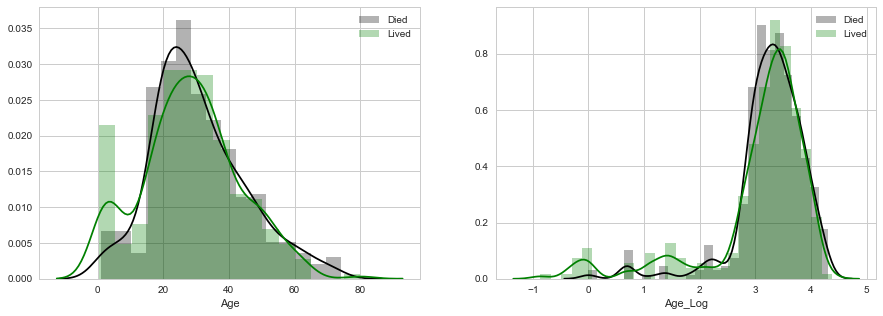

In [39]:
n = label_fig_n()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(train_df[(train_df["Survived"] == 0) & (train_df['Age'].notnull())]['Age'], 
             label='Died', color='k', ax=ax[0], hist_kws=dict(alpha=0.3))
sns.distplot(train_df[(train_df["Survived"] == 1) & (train_df['Age'].notnull())]['Age'], 
             label='Lived', color='g', ax=ax[0], hist_kws=dict(alpha=0.3))

sns.distplot(train_df[(train_df["Survived"] == 0) & (train_df['Age_Log'].notnull())]['Age_Log'], 
             label='Died', color='k', ax=ax[1], hist_kws=dict(alpha=0.3))
sns.distplot(train_df[(train_df["Survived"] == 1) & (train_df['Age_Log'].notnull())]['Age_Log'], 
             label='Lived', color='g', ax=ax[1], hist_kws=dict(alpha=0.3))

ax[0].legend()
ax[1].legend();

Well, it's closer to a normal distribution, but now is slightly left skewed. Keep the modified feature for now. (I will make various feature sets for the ML algorithms later where one of these is dropped in each).  

Second, this can be ordinally done by binning the age into buckets. These buckets could be equally distributed (e.g., every 10 years) or non-equally distributed (e.g., 0-5, 5.1-12, 12.1-18, 18.1-25, 25.1-35, 35.1-50, 50.1+). Try both. From <a href='#fig_d'>Figure 4a</a>, an equal bucket size of every 5 years seems to be reasonable. For non-equal, use [0.0-5.0, 5.1-12.0, 12.1-18.0, 18.1-25, 25.1-35.0, 35.1-50.0, 50.1+], which is sort of like taking log scale and then binning.

In [40]:
train_df['Age_Bucket_Equal'] = train_df['Age'].apply(lambda x: x//5 if pd.notnull(x) else x)

In [41]:
def age_buckets_unequal(age):
    if age < 5.0:            return 0
    elif 5.0 <= age < 12.0:  return 1
    elif 12.0 <= age < 18.0: return 2
    elif 18.0 <= age < 25.0: return 3
    elif 25.0 <= age < 35.0: return 4
    elif 35.0 <= age < 50.0: return 5
    else:                    return 6
    
train_df['Age_Bucket_Unequal'] = train_df['Age'].apply(lambda x: age_buckets_unequal(x) if pd.notnull(x) else x)

To see how this affected things, redo correlation plot:

#### Figure 5 ####

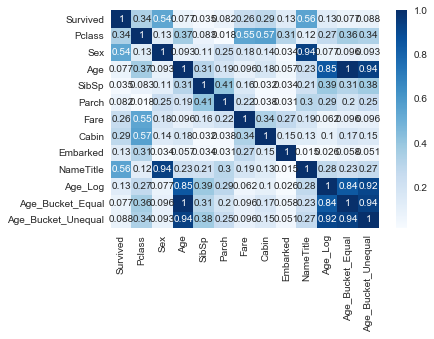

In [42]:
n = label_fig_n()
sns.heatmap(abs(train_df.corr()), annot=True, cmap='Blues');

**Log Transform**:  
\- Higher correlation to Survival, SibSp, Parch than Age
\- Lower correlation to Pclass 
\- Only 0.85 correlation to Age - not surprising  

**Ordinal Bucket Transform**:  
\- Perfect correlation to Age - Should be!  
\- Basically all correlations to other Features and Survival are the same as Age.  

**Takeaways**  
**1. Log Transformation of Age is a more normal distribution (compared to Age) - GOOD**  
**2. Log Transformation of Age has a higher correlation to Survival and lower correlation to Pclass - GOOD**  
**3. Ordinal Bucketing of equal spacing does nothing. It's a linear transform.**  
**4. Ordinal Bucketing of unequal spacing does not much. Like Log Transform, there's higher correlation to Survival and lower correlation to Pclass**  
**5. Only thing worth keeping is Log Transform**

In [43]:
train_df.drop(["Age_Bucket_Equal", "Age_Bucket_Unequal"], axis=1, inplace=True)

### Fare Transformation ###
Do the same log transformation. Only issue is that some Fares are 0, which cannot be log transformmed, these should be set to log of 1 (small, but not fraction).

#### Figure 6 ####

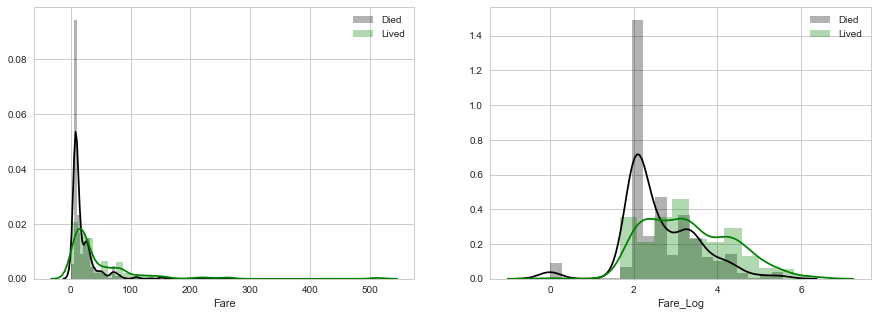

In [44]:
# Take log of age and append to new feature
def fare_log(fare):
    if pd.isnull(fare): return fare
    elif fare == 0:     return np.log(1)
    else:               return np.log(fare)

train_df['Fare_Log'] = train_df['Fare'].apply(lambda x: fare_log(x))

n = label_fig_n()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(train_df[(train_df["Survived"] == 0) & (train_df['Fare'].notnull())]['Fare'], 
             label='Died', color='k', ax=ax[0], hist_kws=dict(alpha=0.3))
sns.distplot(train_df[(train_df["Survived"] == 1) & (train_df['Fare'].notnull())]['Fare'], 
             label='Lived', color='g', ax=ax[0], hist_kws=dict(alpha=0.3))

sns.distplot(train_df[(train_df["Survived"] == 0) & (train_df['Fare_Log'].notnull())]['Fare_Log'], 
             label='Died', color='k', ax=ax[1], hist_kws=dict(alpha=0.3))
sns.distplot(train_df[(train_df["Survived"] == 1) & (train_df['Fare_Log'].notnull())]['Fare_Log'], 
             label='Lived', color='g', ax=ax[1], hist_kws=dict(alpha=0.3))

ax[0].legend()
ax[1].legend();

#### Figure 7 ####

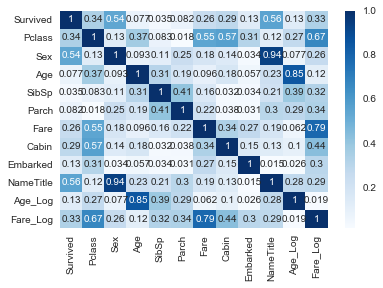

In [45]:
# Replot correlation
n = label_fig_n()
sns.heatmap(abs(train_df.corr()), annot=True, cmap='Blues');

**Takeaways**  
**1. Log Transformation of Fare is not much more of normal distribution (compare to Fare)**  
**2. Log Transformation of Fare has higher correlation to Survived, but also to Pclass and just about every other feature**  
**3. Keep both log and regular Fare for now**

<a id='eng_2'></a>  
## FE 2.2) Imputation ##
***
Answer the following questions:  
**1. Are there features that are missing values?**  
**2. Is there a good way to *impute* these from other passengers?**

In general this information is already known from df.info(). This can be visualized as well through seaborn heatmap.  

*Note, using temp_df for some of this because it has null data not transformed.*

#### Figure 8 ####

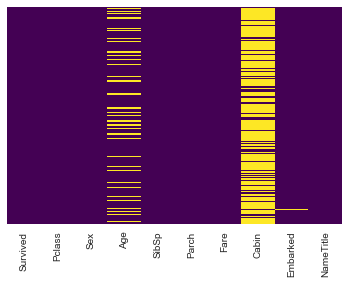

In [46]:
label_fig_n()
sns.heatmap(temp_df.isnull(), yticklabels=False, cbar=False, cmap='viridis');

Based on info(), there are three features that are missing information, "Age", "Cabin", and "Embarked".  But just to verify, find out if there are others:

In [47]:
for col in temp_df.columns:
    if any(temp_df[col].isnull()):
        print(col)

Age
Cabin
Embarked


### Embarked ###
There are 2 missing values for Embarked, what do those passengers look like.

In [48]:
null_emb_ix = train_df[train_df['Embarked'] == -1].index
train_df.loc[null_emb_ix]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,NameTitle,Age_Log,Fare_Log
61,1,1,0,38.0,0,0,80.0,1,-1,0,3.637586,4.382027
829,1,1,0,62.0,0,0,80.0,1,-1,1,4.127134,4.382027


They are very identical, other than NameTitle, both of which are female.  What are the Embarked values for other passengers with similar characteristics?

In [49]:
train_df[(train_df['Survived'] == 1) & (train_df['Pclass'] == 1) & (train_df['Sex'] == 0) 
         & (train_df['SibSp'] == 0) & (train_df['Parch'] == 0) & (train_df['Cabin'] == 1)]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,NameTitle,Age_Log,Fare_Log
61,1,1,0,38.0,0,0,80.0000,1,-1,0,3.637586,4.382027
194,1,1,0,44.0,0,0,27.7208,1,0,1,3.784190,3.322183
195,1,1,0,58.0,0,0,146.5208,1,0,0,4.060443,4.987167
257,1,1,0,30.0,0,0,86.5000,1,1,0,3.401197,4.460144
369,1,1,0,24.0,0,0,69.3000,1,0,0,3.178054,4.238445
504,1,1,0,16.0,0,0,86.5000,1,1,0,2.772589,4.460144
520,1,1,0,30.0,0,0,93.5000,1,1,0,3.401197,4.537961
641,1,1,0,24.0,0,0,69.3000,1,0,0,3.178054,4.238445
730,1,1,0,29.0,0,0,211.3375,1,1,0,3.367296,5.353456
759,1,1,0,33.0,0,0,86.5000,1,1,2,3.496508,4.460144


There doesn't seem to be any specific Embarked for these other than they are (0) C or (1) S, not (2) Q.  Age does not seem to matter, nor does NameTitle. Let's see if there are more people from C or S in general.

In [50]:
train_df['Embarked'].value_counts()

 1    644
 0    168
 2     77
-1      2
Name: Embarked, dtype: int64

Clearly there are more from S than C in general, so this doesn't help us because we have more S than C in the above.  I think that anything we do here is likely backfire, and the only proper option is to drop these.

In [51]:
train_df.drop(null_emb_ix, axis=0, inplace=True)

### Age ###
This could be done simply by taking the mean/median age of all passengers, but it will (hopefully) turn out better to impute ages based on a smarter algorithm. Using correlation information from <a href='#fig_b'>Figure 2</a>, Pclass and SibSp correlate the most to Age.

In [52]:
# So as not to bias things, create a copy of train dataframe (can clear and reset temp_df)
temp_df = train_df.copy()

# Loop through all rows that have a missing age
for ix in train_df[train_df['Age'].isnull()].index:
    
    # Get the mean age of all passengers with same Pclass, SibSp
    passenger = train_df.loc[ix]
    train_df['Age'].loc[ix] = temp_df[(temp_df['Age'].notnull()) & 
                                      (temp_df['Pclass'] == passenger['Pclass']) &
                                      (temp_df['SibSp'] == passenger['SibSp'])]['Age'].mean()

### Cabin ###
Because there are so few Cabin values (23%), it's possible that dropping this feature will be best. However, <a href='#fig_d'>Figure 4</a> did sow that knowing the cabin is useful, and imputing the cabin for so many missing values is likely to be erroneous. For now, leave Cabin as is, with unknown cabins as "nan" meaning unkown. 

#### Take a look at the data ####

In [53]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
Survived     889 non-null int64
Pclass       889 non-null int64
Sex          889 non-null int64
Age          882 non-null float64
SibSp        889 non-null int64
Parch        889 non-null int64
Fare         889 non-null float64
Cabin        889 non-null int64
Embarked     889 non-null int64
NameTitle    889 non-null int64
Age_Log      712 non-null float64
Fare_Log     889 non-null float64
dtypes: float64(4), int64(8)
memory usage: 130.3 KB


Sigh. There's still some null data for Age, which means that imputation didn't work because the comparisons in the foor loop led to some sets with no values.  Why?

In [54]:
train_df[train_df['Age'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,NameTitle,Age_Log,Fare_Log
159,0,3,1,NaN,8,2,69.55,-1,1,2,NaN,4.242046
180,0,3,0,NaN,8,2,69.55,-1,1,0,NaN,4.242046
201,0,3,1,NaN,8,2,69.55,-1,1,5,NaN,4.242046
324,0,3,1,NaN,8,2,69.55,-1,1,5,NaN,4.242046
792,0,3,0,NaN,8,2,69.55,-1,1,0,NaN,4.242046
846,0,3,1,NaN,8,2,69.55,-1,1,5,NaN,4.242046
863,0,3,0,NaN,8,2,69.55,-1,1,0,NaN,4.242046


Ok, I see it now, these are here because of 'SibSp' being 8 siblings and spouses, which no one else has. It is likely that this is one large family (that did not survive). All of these passengers paid for tickets, so they are not employees. There are two most likely scenarios: 1) They are all children of one family, and thus likely 18 or under, or 2) they are one big older family on a trip with their parents (maybe a parent's 60th birthday?). I'm going to go with scenario (1) and give them a random age between 5 and 18.

In [55]:
# Get the indices of these null value Ages and set as a random value b/w 5-18
ix = train_df[train_df['Age'].isnull()].index
train_df['Age'].loc[ix] = 5 + 13 * np.random.rand(7)

Now that Age has been imputed, Age_Log needs to be redone to transform the new imputed ages

In [56]:
train_df['Age_Log'] = train_df['Age'].apply(lambda x: np.log(x))

#### Take one last look at the data ####

In [57]:
train_df.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,NameTitle,Age_Log,Fare_Log
0,0,3,1,22.0,1,0,7.2500,-1,1,5,3.091042,1.981001
1,1,1,0,38.0,1,0,71.2833,2,0,1,3.637586,4.266662
2,1,3,0,26.0,0,0,7.9250,-1,1,0,3.258097,2.070022
3,1,1,0,35.0,1,0,53.1000,2,1,1,3.555348,3.972177
4,0,3,1,35.0,0,0,8.0500,-1,1,5,3.555348,2.085672


In [58]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
Survived     889 non-null int64
Pclass       889 non-null int64
Sex          889 non-null int64
Age          889 non-null float64
SibSp        889 non-null int64
Parch        889 non-null int64
Fare         889 non-null float64
Cabin        889 non-null int64
Embarked     889 non-null int64
NameTitle    889 non-null int64
Age_Log      889 non-null float64
Fare_Log     889 non-null float64
dtypes: float64(4), int64(8)
memory usage: 130.3 KB


In [59]:
train_df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,NameTitle,Age_Log,Fare_Log
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,0.649044,29.369918,0.524184,0.382452,32.096681,-0.226097,0.897638,3.208099,3.216434,2.890498
std,0.486260,0.834700,0.477538,13.294038,1.103705,0.806761,49.697504,1.591629,0.515181,2.187315,0.715577,1.001535
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-0.867501,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.895800,-1.000000,1.000000,1.000000,3.091042,2.066331
50%,0.000000,3.000000,1.000000,27.630201,0.000000,0.000000,14.454200,-1.000000,1.000000,5.000000,3.318909,2.670985
75%,1.000000,3.000000,1.000000,36.500000,1.000000,0.000000,31.000000,-1.000000,1.000000,5.000000,3.597312,3.433987
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,7.000000,2.000000,5.000000,4.382027,6.238967


### Great!! We now have data that is all real, numerical, and positive ###  
***
<a id='eng_3'></a> 
## FE 2.3) Categorical Binarization ## 
***
The last thing to do here is to transform the data that was previously categorical back to being categorical, and then use pd.get_dummies to expand these to binarized features, which is necessary for most ML models. This does not need to be done for Sex because it's a binary feature already, which is all that would be done. To use pd.get_dummies correctly, get all the dummy features and drop the last one to avoid singularities.

************************************ CONSIDER MERF model - can I do feature importance with categorical data as categorical or does it need to be numerical as above? If os, do importance this way.  

In [60]:
# Create function to convert numerical to numerical categorical data
def int_to_cat(df, col, feature_dict_rev):
    
    # Modify each categorical label of the feature to the corresponding integer, set any nan to -1
    df[col] = df[col].apply(lambda x: feature_dict_rev[col][x])
    
    return df

# We don't need to do this for Sex because it's already binary
for col in ["Cabin", "Embarked", "NameTitle"]:
    train_df = int_to_cat(train_df, col, feature_dict_rev)

# Show head for verification
train_df.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,NameTitle,Age_Log,Fare_Log
0,0,3,1,22.0,1,0,7.2500,nan,S,Mr,3.091042,1.981001
1,1,1,0,38.0,1,0,71.2833,C,C,Mrs,3.637586,4.266662
2,1,3,0,26.0,0,0,7.9250,nan,S,Miss,3.258097,2.070022
3,1,1,0,35.0,1,0,53.1000,C,S,Mrs,3.555348,3.972177
4,0,3,1,35.0,0,0,8.0500,nan,S,Mr,3.555348,2.085672


In [61]:
# Create a function to get dummy encoding features and append to dataframe
def encode_dummies(df, col):
    
    # Encode dummy features and drop last features
    dummy_df = pd.get_dummies(df[col], prefix=col)
    dummy_df.drop(dummy_df.columns[-1], axis=1, inplace=True)
    
    # Append the new dummy features to the original dataframe and drop the original
    # that was dummified
    df[dummy_df.columns] = dummy_df
    return df.drop([col], axis=1)

# Again, We don't need to do this for Sex because it's already binary
for col in ["Cabin", "Embarked", "NameTitle"]:
    train_df = encode_dummies(train_df, col)

<a id='eng_4'></a> 
## FE 2.4) Normalization ## 
***
Many of the machine learning models require Features to be normalized to a mean of 0 and a standard deviation of 1. Scikit Learn has a nice tool for this - StandardScaler. It will make the binary data look a little odd, but this won't matter as there will still only be two possible values, they just won't be 0 or 1. The data can always be transformed back later using an inverse transform.

In [62]:
# Create a new dataframe here that will be the scaled data
scaled_train_df = train_df.copy()

scaler = StandardScaler()
scaler.fit(scaled_train_df.drop(["Survived"], axis=1))
scaled_train_df[scaled_train_df.columns[1:]] = scaler.transform(scaled_train_df.drop(["Survived"], axis=1))
scaled_train_df.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Age_Log,Fare_Log,Cabin_A,...,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,NameTitle_Elite,NameTitle_Military,NameTitle_Miss,NameTitle_Mr,NameTitle_Mrs
0,0,0.825209,0.735342,-0.554690,0.431350,-0.474326,-0.500240,-0.175330,-0.908614,-0.131006,...,-0.12182,-0.067229,-0.033558,-0.482711,-0.307941,-0.249252,-0.075207,-0.512625,0.848255,-0.402606
1,1,-1.572211,-1.359911,0.649535,0.431350,-0.474326,0.788947,0.588881,1.374828,-0.131006,...,-0.12182,-0.067229,-0.033558,2.071634,-0.307941,-0.249252,-0.075207,-0.512625,-1.178891,2.483819
2,1,0.825209,-1.359911,-0.253634,-0.475199,-0.474326,-0.486650,0.058255,-0.819680,-0.131006,...,-0.12182,-0.067229,-0.033558,-0.482711,-0.307941,-0.249252,-0.075207,1.950745,-1.178891,-0.402606
3,1,-1.572211,-1.359911,0.423743,0.431350,-0.474326,0.422861,0.473890,1.080629,-0.131006,...,-0.12182,-0.067229,-0.033558,-0.482711,-0.307941,-0.249252,-0.075207,-0.512625,-1.178891,2.483819
4,0,0.825209,0.735342,0.423743,-0.475199,-0.474326,-0.484133,0.473890,-0.804045,-0.131006,...,-0.12182,-0.067229,-0.033558,-0.482711,-0.307941,-0.249252,-0.075207,-0.512625,0.848255,-0.402606


<a id='eng_5'></a> 
## FE 2.5) Feature Importance & PCA## 
***
Now that the features have been engineered, imputed, transformed, dropped, whatever, it's seems like a good time to have a look at Feature Importance and Principal Component Analysis (PCA). Feature Importance can help to make decisions on if some features can be dropped to help algorithm performance (speed and accuracy).  PCA might provide a means to turn all of these features into a much smaller dimensional space, 1 or 2 even, that could be visualized easily. For feature importance, there is a really nice module called Boruta but that is not in kaggle space, so I will borrow a very useful model importance function from the <a href='https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial'>Kaggle tutorial by Helge Bjorland</a>.

In [63]:
# from https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial
def plot_feature_importance(X, y, ax=None):
    tree = DecisionTreeClassifier(random_state=0)
    tree.fit(X, y)
    imp = pd.DataFrame(tree.feature_importances_  , columns=['Importance'], index=X.columns)
    imp = imp.sort_values(['Importance'], ascending=True)
    imp.plot(kind='barh', ax=ax)

This seems like the opportune time to build a dictionary of different feature sets that will be tested as things proceed, and while at it, create X, y splits

In [64]:
x_y_sets = dict()
x_y_sets['std'] = {"X": train_df.drop(["Survived", "Age_Log", "Fare_Log"], axis=1), 
                   "y": train_df['Survived']}
x_y_sets['log'] = {"X": train_df.drop(["Survived", "Age", "Fare"], axis=1), 
                   "y": train_df['Survived']}
x_y_sets['scaled_std'] = {"X": scaled_train_df.drop(["Survived", "Age_Log", "Fare_Log"], axis=1), 
                          "y": scaled_train_df['Survived']}
x_y_sets['scaled_log'] = {"X": scaled_train_df.drop(["Survived", "Age", "Fare"], axis=1), 
                          "y": scaled_train_df['Survived']}

#### Figure 9 ####

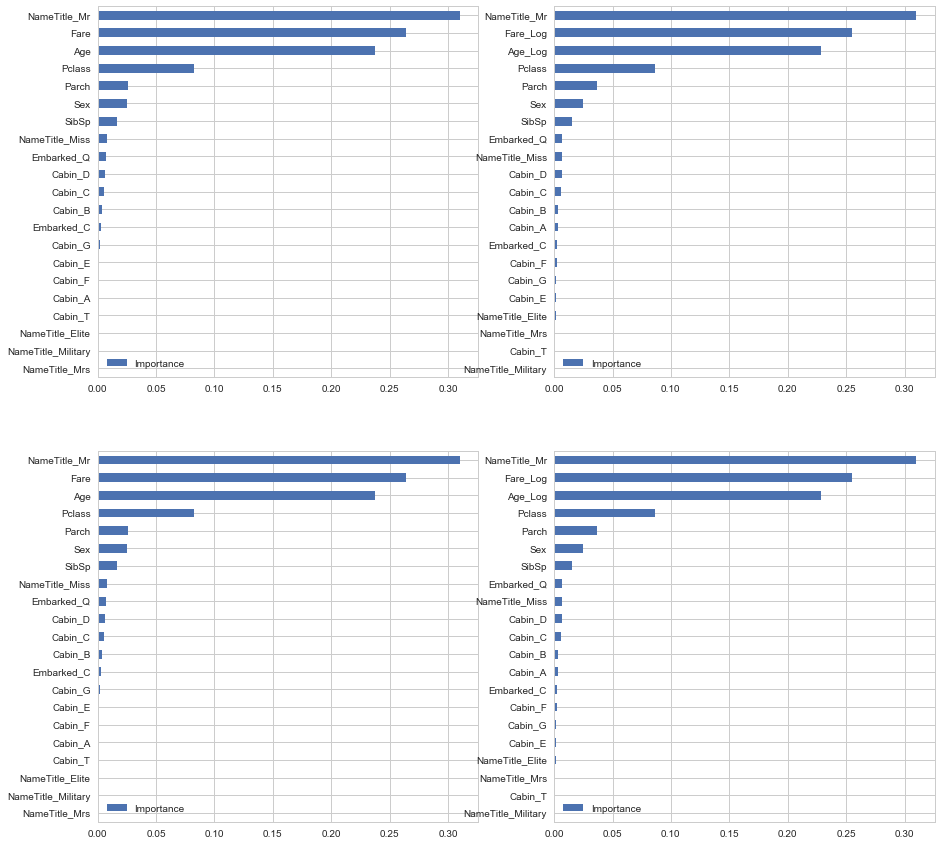

In [65]:
# Plot the different sets and the feature importance
n = label_fig_n()
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
plot_feature_importance(x_y_sets['std']['X'], x_y_sets['std']['y'], ax=ax[0, 0])
plot_feature_importance(x_y_sets['log']['X'], x_y_sets['log']['y'], ax=ax[0, 1])
plot_feature_importance(x_y_sets['scaled_std']['X'], x_y_sets['scaled_std']['y'], ax=ax[1, 0])
plot_feature_importance(x_y_sets['scaled_log']['X'], x_y_sets['scaled_log']['y'], ax=ax[1, 1])

**Takeaways**  
**1. Log Transforms seem to have less importance than untransformed**  
**2. Pclass is not as important as might have been expected** - Surprised  
**3. Sex is the 6th most important feature** - I don't actually understand why.  I would have expected this to be the most important feature of all of them. I'm a little stumped as to why and would love anyone's thoughts here. 

*I'm not really sure what to think about all this, and may need to revisit this at another time.*
***

#### PCA ####
It may be useful to reduce dimensionality and visualize the principal component analysis of the feature sets. PCA simply tries to create lower dimensional variables that have the most variance and can possibly used a reduced feature set with simplier ML models. PCA *only* works if the features are scaled, so only do this on scaled features. Unscaled PCA shown for illustrative purposes.

#### Figure 10 ####

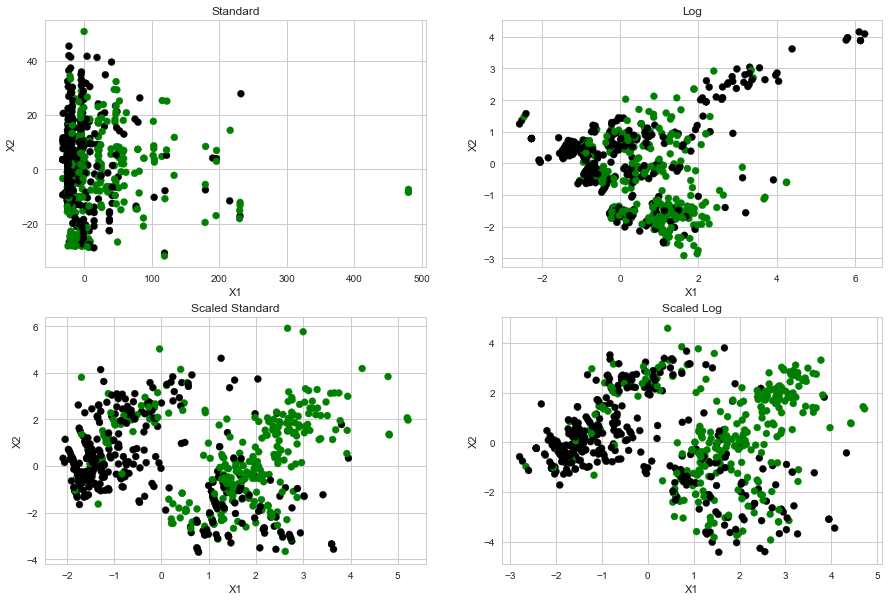

In [66]:
pca = PCA(n_components=2)
X_std_pca = pca.fit_transform(x_y_sets['std']['X'])
X_log_pca = pca.fit_transform(x_y_sets['log']['X'])
X_scaled_std_pca = pca.fit_transform(x_y_sets['scaled_std']['X'])
X_scaled_log_pca = pca.fit_transform(x_y_sets['scaled_log']['X'])

def plot_pca(X_pca, y, title, ax):
    c = [(lambda x: 'g' if x else 'k')(x) for x in y]
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=c)
    ax.set(xlabel="X1", ylabel="X2", title=title)
    
# Plot the PCA first 2 components
n = label_fig_n()
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
plot_pca(X_std_pca, x_y_sets['std']['y'], "Standard", ax[0,0])
plot_pca(X_log_pca, x_y_sets['log']['y'], "Log", ax[0,1])
plot_pca(X_scaled_std_pca, x_y_sets['scaled_std']['y'], "Scaled Standard", ax[1,0])
plot_pca(X_scaled_log_pca, x_y_sets['scaled_log']['y'], "Scaled Log", ax[1,1])

**Takeaways**  
**1. As noted, unscaled data does not work with PCA**  
**2. PCA space shows some binary discrimination ** - There does appear to be some discrimination in PCA space, and perhaps in 3 dimensions it might be good enough for binary classification (lived/died). This may be worth exploring later in feature selection for different models.  
***

In [ ]:
# DO LDA here too!!!

<a id='ml'></a> 
# Part 3: Machine Learning# 
***